✅ All helper files are ready.
Loading all models...
✅ All models loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


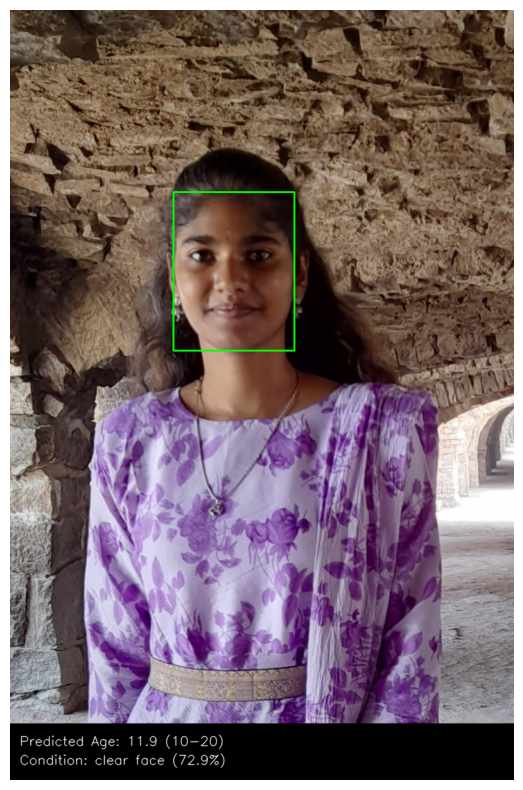

In [ ]:
# I'm importing all the necessary libraries for this project.
# TensorFlow and NumPy are for the deep learning model and numerical operations.
# OpenCV (cv2) and dlib are for the computer vision tasks like face and landmark detection.
# Matplotlib is for displaying the final image in the notebook.
import tensorflow as tf
import numpy as np
import os
import dlib
import cv2 # OpenCV
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import requests
import bz2

# This first section is a setup step. I've written it to be self-contained.
# It checks if the pre-trained models for face detection (OpenCV's DNN) and landmark prediction (dlib) exist.
# If they don't, it automatically downloads them. This makes the script easy to run in any environment.
# Download necessary detector models
prototxt_url = 'https://github.com/opencv/opencv/raw/master/samples/dnn/face_detector/deploy.prototxt'
caffemodel_url = 'https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel'
if not os.path.exists('deploy.prototxt'):
    !wget -q {prototxt_url}
if not os.path.exists('res10_300x300_ssd_iter_140000_fp16.caffemodel'):
    !wget -q {caffemodel_url}

# Download dlib facial landmark predictor
predictor_url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
predictor_path = 'shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    !wget -q {predictor_url}
    import bz2
    with bz2.BZ2File(predictor_url.split('/')[-1], 'rb') as f_in, open(predictor_path, 'wb') as f_out:
        f_out.write(f_in.read())
print(" All helper files are ready.")


# --- 2. LOAD ALL MODELS ---
# I created this function to load all the heavy models into memory just once.
# This is more efficient than loading them every time I want to analyze an image.
def load_all_models(skin_model_path, age_model_path):
    print("Loading all models...")
    # Here, I load the pre-trained face detector from OpenCV.
    face_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000_fp16.caffemodel')
    # This loads the dlib landmark predictor which finds key points on a face.
    landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    # Finally, I load my two custom-trained Keras models. I use compile=False for faster loading since I'm only doing predictions.
    skin_model = tf.keras.models.load_model(skin_model_path, compile=False)
    age_model = tf.keras.models.load_model(age_model_path, compile=False)
    print(" All models loaded successfully!")
    return face_net, landmark_predictor, skin_model, age_model


# --- 3. THE MAIN ANALYSIS AND VISUALIZATION FUNCTION ---
# This is the main function that ties everything together. It takes an image path and produces the final annotated image.
def run_full_pipeline(image_path, face_net, landmark_predictor, skin_model, age_model):
    # I define the class names for my skin condition model here.
    skin_class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
    IMG_SIZE = 224

    # First, I load the image using OpenCV.
    image = cv2.imread(image_path)
    if image is None: return print("Error: Image not found.")

    # I then resize it to a standard width. I learned this is important to make sure
    # my text annotations look consistent, whether the original image is large or small.
    STANDARD_WIDTH = 800
    (h_orig, w_orig) = image.shape[:2]
    ratio = STANDARD_WIDTH / w_orig
    new_height = int(h_orig * ratio)
    image = cv2.resize(image, (STANDARD_WIDTH, new_height), interpolation=cv2.INTER_AREA)

    output_image = image.copy()
    (h, w) = image.shape[:2]

    # Here, I use the pre-trained OpenCV DNN to detect faces. It's more robust than older methods.
    # I find the detection with the highest confidence and only proceed if it's above 50%.
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    best_detection_index = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, best_detection_index, 2]

    if confidence < 0.5:
        print("No face detected.")
        return image

    # I get the coordinates of the face box from the detection.
    box = detections[0, 0, best_detection_index, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # I crop the detected face from the image. This is the region our trained models will analyze.
    cropped_face = image[startY:endY, startX:endX]
    if cropped_face.size == 0:
        print("Face detection resulted in an empty crop.")
        return image

    # This is a critical step: I resize the crop to 224x224 and apply the specific ResNetV2 preprocessing.
    # This formats the data exactly as the models expect. Using np.copy() here is a safeguard against potential errors.
    resized_face = tf.image.resize(cropped_face, [IMG_SIZE, IMG_SIZE])
    img_batch = np.expand_dims(resized_face, axis=0)
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(np.copy(img_batch))

    # Here I run the predictions, feeding the preprocessed face to both of my trained models.
    skin_probs = skin_model.predict(preprocessed_img)
    skin_class = skin_class_names[np.argmax(skin_probs[0])]
    skin_conf = np.max(skin_probs[0]) * 100

    age_pred = age_model.predict(preprocessed_img)[0][0]
    # I ensure the predicted age is never negative.
    age_pred = max(0, age_pred)
    # I also calculate the age range based on the specific age predicted.
    age_range_start = int(age_pred // 10) * 10
    age_range = f"{age_range_start}-{age_range_start + 10}"

    # --- DRAW VISUALIZATIONS ---
    # In this section, I draw all the annotations on the image.

    # First, I draw the main green face box.
    cv2.rectangle(output_image, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # Then, I use the dlib landmark predictor to find the 68 key points on the face.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_rect = dlib.rectangle(int(startX), int(startY), int(endX), int(endY))
    landmarks = landmark_predictor(gray, face_rect)

    # I implemented a "smart" logic here. If the model predicts 'wrinkles' or 'puffy eyes',
    # I use the eye landmarks to draw specific yellow highlight boxes.
    if skin_class == 'puffy eyes' or skin_class == 'wrinkles':
        left_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
        right_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
        cv2.rectangle(output_image, cv2.boundingRect(left_eye_pts), (0, 255, 255), 2)
        cv2.rectangle(output_image, cv2.boundingRect(right_eye_pts), (0, 255, 255), 2)

    # Finally, I decided to use a static banner at the bottom for the text.
    # This is the most robust method to ensure the predictions are always visible and readable.
    banner_height = 90
    cv2.rectangle(output_image, (0, h - banner_height), (w, h), (0, 0, 0), -1)

    age_text = f"Predicted Age: {age_pred:.1f} ({age_range})"
    condition_text = f"Condition: {skin_class} ({skin_conf:.1f}%)"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1
    text_color = (255, 255, 255)

    cv2.putText(output_image, age_text, (15, h - 55), font, font_scale, text_color, thickness, cv2.LINE_AA)
    cv2.putText(output_image, condition_text, (15, h - 25), font, font_scale, text_color, thickness, cv2.LINE_AA)

    return output_image


# --- 4. EXAMPLE USAGE ---
# This is the final section where I set the paths to my models and a test image.
# It calls the functions to load the models and run the full pipeline.
# !!! === UPDATE THESE THREE PATHS === !!!
SKIN_MODEL_PATH = '/content/model_skin.h5'
AGE_MODEL_PATH = '/content/age_resnet_simple_model_best_epoch5.h5'
TEST_IMAGE_PATH = '/content/trump.jpg'

if os.path.exists(SKIN_MODEL_PATH) and os.path.exists(AGE_MODEL_PATH) and os.path.exists(TEST_IMAGE_PATH):
    face_net, landmark_predictor, skin_model, age_model = load_all_models(SKIN_MODEL_PATH, AGE_MODEL_PATH)
    final_image = run_full_pipeline(TEST_IMAGE_PATH, face_net, landmark_predictor, skin_model, age_model)

    if final_image is not None:
        # I convert the final image from OpenCV's BGR to RGB for correct display with Matplotlib.
        final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

        # Finally, I display the result using Matplotlib.
        plt.figure(figsize=(10, 10))
        plt.imshow(final_image_rgb)
        plt.axis('off')
        plt.show()
else:
    print(" Error: Please double-check that all three paths at the bottom of the script are correct.")

✅ All helper files are ready.
Loading all models...
✅ All models loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


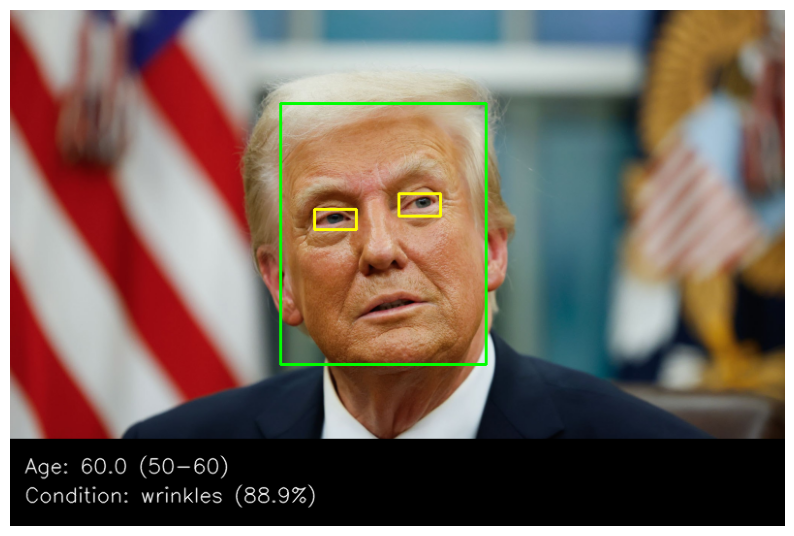

In [ ]:
# I'm importing all the necessary libraries for this project.
# TensorFlow and NumPy are for the deep learning model and numerical operations.
# OpenCV (cv2) and dlib are for the computer vision tasks like face and landmark detection.
# Matplotlib is for displaying the final image in the notebook.
import tensorflow as tf
import numpy as np
import os
import dlib
import cv2 # OpenCV
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import requests
import bz2

# This first section is a setup step. I've written it to be self-contained.
# It checks if the pre-trained models for face detection (OpenCV's DNN) and landmark prediction (dlib) exist.
# If they don't, it automatically downloads them. This makes the script easy to run in any environment.
# Download necessary detector models
prototxt_url = 'https://github.com/opencv/opencv/raw/master/samples/dnn/face_detector/deploy.prototxt'
caffemodel_url = 'https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel'
if not os.path.exists('deploy.prototxt'):
    !wget -q {prototxt_url}
if not os.path.exists('res10_300x300_ssd_iter_140000_fp16.caffemodel'):
    !wget -q {caffemodel_url}

# Download dlib facial landmark predictor
predictor_url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
predictor_path = 'shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    !wget -q {predictor_url}
    import bz2
    with bz2.BZ2File(predictor_url.split('/')[-1], 'rb') as f_in, open(predictor_path, 'wb') as f_out:
        f_out.write(f_in.read())
print(" All helper files are ready.")


# --- 2. LOAD ALL MODELS ---
# I created this function to load all the heavy models into memory just once.
# This is more efficient than loading them every time I want to analyze an image.
def load_all_models(skin_model_path, age_model_path):
    print("Loading all models...")
    # Here, I load the pre-trained face detector from OpenCV.
    face_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000_fp16.caffemodel')
    # This loads the dlib landmark predictor which finds key points on a face.
    landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    # Finally, I load my two custom-trained Keras models. I use compile=False for faster loading since I'm only doing predictions.
    skin_model = tf.keras.models.load_model(skin_model_path, compile=False)
    age_model = tf.keras.models.load_model(age_model_path, compile=False)
    print(" All models loaded successfully!")
    return face_net, landmark_predictor, skin_model, age_model


# --- 3. THE MAIN ANALYSIS AND VISUALIZATION FUNCTION ---
# This is the main function that ties everything together. It takes an image path and produces the final annotated image.
def run_full_pipeline(image_path, face_net, landmark_predictor, skin_model, age_model):
    # I define the class names for my skin condition model here.
    skin_class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
    IMG_SIZE = 224

    # First, I load the image using OpenCV.
    image = cv2.imread(image_path)
    if image is None: return print("Error: Image not found.")

    # I then resize it to a standard width. I learned this is important to make sure
    # my text annotations look consistent, whether the original image is large or small.
    STANDARD_WIDTH = 800
    (h_orig, w_orig) = image.shape[:2]
    ratio = STANDARD_WIDTH / w_orig
    new_height = int(h_orig * ratio)
    image = cv2.resize(image, (STANDARD_WIDTH, new_height), interpolation=cv2.INTER_AREA)

    output_image = image.copy()
    (h, w) = image.shape[:2]

    # Here, I use the pre-trained OpenCV DNN to detect faces. It's more robust than older methods.
    # I find the detection with the highest confidence and only proceed if it's above 50%.
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    best_detection_index = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, best_detection_index, 2]

    if confidence < 0.5:
        print("No face detected.")
        return image

    # I get the coordinates of the face box from the detection.
    box = detections[0, 0, best_detection_index, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # I crop the detected face from the image. This is the region our trained models will analyze.
    cropped_face = image[startY:endY, startX:endX]
    if cropped_face.size == 0:
        print("Face detection resulted in an empty crop.")
        return image

    # This is a critical step: I resize the crop to 224x224 and apply the specific ResNetV2 preprocessing.
    # This formats the data exactly as the models expect. Using np.copy() here is a safeguard against potential errors.
    resized_face = tf.image.resize(cropped_face, [IMG_SIZE, IMG_SIZE])
    img_batch = np.expand_dims(resized_face, axis=0)
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(np.copy(img_batch))

    # Here I run the predictions, feeding the preprocessed face to both of my trained models.
    skin_probs = skin_model.predict(preprocessed_img)
    skin_class = skin_class_names[np.argmax(skin_probs[0])]
    skin_conf = np.max(skin_probs[0]) * 100

    age_pred = age_model.predict(preprocessed_img)[0][0]
    # I ensure the predicted age is never negative.
    age_pred = max(0, age_pred)
    # I also calculate the age range based on the specific age predicted.
    age_range_start = int(age_pred // 10) * 10
    age_range = f"{age_range_start}-{age_range_start + 10}"

    # --- DRAW VISUALIZATIONS ---
    # In this section, I draw all the annotations on the image.

    # First, I draw the main green face box.
    cv2.rectangle(output_image, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # Then, I use the dlib landmark predictor to find the 68 key points on the face.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_rect = dlib.rectangle(int(startX), int(startY), int(endX), int(endY))
    landmarks = landmark_predictor(gray, face_rect)

    # I implemented a "smart" logic here. If the model predicts 'wrinkles' or 'puffy eyes',
    # I use the eye landmarks to draw specific yellow highlight boxes.
    if skin_class == 'puffy eyes' or skin_class == 'wrinkles':
        left_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
        right_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
        cv2.rectangle(output_image, cv2.boundingRect(left_eye_pts), (0, 255, 255), 2)
        cv2.rectangle(output_image, cv2.boundingRect(right_eye_pts), (0, 255, 255), 2)

    # Finally, I decided to use a static banner at the bottom for the text.
    # This is the most robust method to ensure the predictions are always visible and readable.
    banner_height = 90
    cv2.rectangle(output_image, (0, h - banner_height), (w, h), (0, 0, 0), -1)

    age_text = f"Predicted Age: {age_pred:.1f} ({age_range})"
    condition_text = f"Condition: {skin_class} ({skin_conf:.1f}%)"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1
    text_color = (255, 255, 255)

    cv2.putText(output_image, age_text, (15, h - 55), font, font_scale, text_color, thickness, cv2.LINE_AA)
    cv2.putText(output_image, condition_text, (15, h - 25), font, font_scale, text_color, thickness, cv2.LINE_AA)

    return output_image


# --- 4. EXAMPLE USAGE ---
# This is the final section where I set the paths to my models and a test image.
# It calls the functions to load the models and run the full pipeline.
# !!! === UPDATE THESE THREE PATHS === !!!
SKIN_MODEL_PATH = '/content/model_skin.h5'
AGE_MODEL_PATH = '/content/age_resnet_simple_model_best_epoch5.h5'
TEST_IMAGE_PATH = '/content/trump.jpg'

if os.path.exists(SKIN_MODEL_PATH) and os.path.exists(AGE_MODEL_PATH) and os.path.exists(TEST_IMAGE_PATH):
    face_net, landmark_predictor, skin_model, age_model = load_all_models(SKIN_MODEL_PATH, AGE_MODEL_PATH)
    final_image = run_full_pipeline(TEST_IMAGE_PATH, face_net, landmark_predictor, skin_model, age_model)

    if final_image is not None:
        # I convert the final image from OpenCV's BGR to RGB for correct display with Matplotlib.
        final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

        # Finally, I display the result using Matplotlib.
        plt.figure(figsize=(10, 10))
        plt.imshow(final_image_rgb)
        plt.axis('off')
        plt.show()
else:
    print("Error: Please double-check that all three paths at the bottom of the script are correct.")

In [ ]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.5 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import os
import dlib
import cv2
from PIL import Image
import requests
import bz2

# --- 1. PAGE CONFIGURATION ---
st.set_page_config(
    page_title="AI Facial Analysis",
    page_icon="🤖",
    layout="centered"
)

# --- 2. HELPER & MODEL LOADING (CACHED FOR PERFORMANCE) ---
@st.cache_resource
def load_all_models_and_predictors(skin_model_path, age_model_path):
    """
    Downloads helper files and loads all models into memory.
    This function is cached so it only runs once.
    """
    # --- Download Helper Files ---
    def download_file(url, output_path, name):
        if not os.path.exists(output_path):
            with st.spinner(f"Downloading {name}..."):
                r = requests.get(url, stream=True)
                with open(output_path, 'wb') as f:
                    f.write(r.content)

    # Download OpenCV DNN Face Detector files
    download_file('https://github.com/opencv/opencv/raw/master/samples/dnn/face_detector/deploy.prototxt', 'deploy.prototxt', 'DNN Prototxt')
    download_file('https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel', 'res10_300x300_ssd_iter_140000_fp16.caffemodel', 'DNN CaffeModel')

    # Download and extract dlib facial landmark predictor
    predictor_path = 'shape_predictor_68_face_landmarks.dat'
    if not os.path.exists(predictor_path):
        download_file('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2', 'shape_predictor_68_face_landmarks.dat.bz2', 'Dlib Predictor')
        with bz2.BZ2File('shape_predictor_68_face_landmarks.dat.bz2', 'rb') as f_in, open(predictor_path, 'wb') as f_out:
            f_out.write(f_in.read())

    # --- Load Models into Memory ---
    face_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000_fp16.caffemodel')
    landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    skin_model = tf.keras.models.load_model(skin_model_path, compile=False)
    age_model = tf.keras.models.load_model(age_model_path, compile=False)

    return face_net, landmark_predictor, skin_model, age_model

# --- 3. THE BACKEND PIPELINE FUNCTION ---
def run_full_pipeline(image, face_net, landmark_predictor, skin_model, age_model):
    skin_class_names = ['clear face', 'dark spots', 'puffy eyes', 'wrinkles']
    IMG_SIZE = 224

    # Standardize input image size for consistent processing
    STANDARD_WIDTH = 800
    (h_orig, w_orig) = image.shape[:2]
    ratio = STANDARD_WIDTH / w_orig
    new_height = int(h_orig * ratio)
    image = cv2.resize(image, (STANDARD_WIDTH, new_height), interpolation=cv2.INTER_AREA)

    output_image = image.copy()
    (h, w) = image.shape[:2]

    # Detect face
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()
    best_detection_index = np.argmax(detections[0, 0, :, 2])
    confidence = detections[0, 0, best_detection_index, 2]

    if confidence < 0.5:
        st.error("No face detected in the image. Please try another one.")
        return None, None

    # Get predictions
    box = detections[0, 0, best_detection_index, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    cropped_face = image[startY:endY, startX:endX]

    if cropped_face.size == 0:
        st.error("Face detection resulted in an empty crop.")
        return None, None

    resized_face = tf.image.resize(cropped_face, [IMG_SIZE, IMG_SIZE])
    img_batch = np.expand_dims(resized_face, axis=0)
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(np.copy(img_batch))

    skin_probs = skin_model.predict(preprocessed_img)
    skin_class = skin_class_names[np.argmax(skin_probs[0])]
    skin_conf = np.max(skin_probs[0]) * 100

    age_pred = age_model.predict(preprocessed_img)[0][0]
    age_pred = max(0, age_pred)
    age_range_start = int(age_pred // 10) * 10
    age_range = f"{age_range_start}-{age_range_start + 10}"

    # --- Draw Visualizations ---
    cv2.rectangle(output_image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_rect = dlib.rectangle(int(startX), int(startY), int(endX), int(endY))
    landmarks = landmark_predictor(gray, face_rect)

    if skin_class == 'puffy eyes' or skin_class == 'wrinkles':
        left_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
        right_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
        cv2.rectangle(output_image, cv2.boundingRect(left_eye_pts), (0, 255, 255), 2)
        cv2.rectangle(output_image, cv2.boundingRect(right_eye_pts), (0, 255, 255), 2)

    results = {
        "skin_class": skin_class, "skin_conf": skin_conf,
        "age_pred": age_pred, "age_range": age_range
    }

    # Add the static information banner
    banner_height = 90
    cv2.rectangle(output_image, (0, h - banner_height), (w, h), (0, 0, 0), -1)
    age_text = f"Predicted Age: {results['age_pred']:.1f} ({results['age_range']})"
    condition_text = f"Condition: {results['skin_class']} ({results['skin_conf']:.1f}%)"
    cv2.putText(output_image, age_text, (15, h - 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(output_image, condition_text, (15, h - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)

    return output_image, results

# --- 4. STREAMLIT USER INTERFACE ---
st.title("🤖 AI Facial Analysis")
st.markdown("Upload an image to detect a face and predict its skin condition and age.")

# Define model paths in Google Drive
SKIN_MODEL_PATH = '/content/model_skin.h5'
AGE_MODEL_PATH = '/content/age_resnet_simple_model_best_epoch5.h5'

# Load models using the cached function
try:
    face_net, landmark_predictor, skin_model, age_model = load_all_models_and_predictors(SKIN_MODEL_PATH, AGE_MODEL_PATH)
except Exception as e:
    st.error(f"Error loading models: {e}. Please ensure model paths in the script are correct and the files are in your Google Drive.")
    st.stop()

# Image Uploader
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Convert the file to an OpenCV image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, 1)

    st.image(image, channels="BGR", caption="Uploaded Image")

    if st.button("Analyze Face"):
        with st.spinner("Processing..."):
            # Run the full pipeline
            annotated_image, results = run_full_pipeline(image, face_net, landmark_predictor, skin_model, age_model)

            # Display results
            if results:
                st.image(annotated_image, channels="BGR", caption="Analysis Result")
                st.subheader("Analysis Details")
                col1, col2 = st.columns(2)
                col1.metric("Predicted Age", f"{results['age_pred']:.1f}", f"{results['age_range']} range")
                col2.metric("Predicted Skin Condition", results['skin_class'].title(), f"{results['skin_conf']:.1f}% confidence")

Writing app.py


In [ ]:
32QWQWmIuuyWHXUq8RKRwnvGB71_4aqhg4ViHYeRPQi3j9S22

In [ ]:
from pyngrok import ngrok

# !!! PASTE YOUR NGROK AUTHTOKEN HERE !!!
NGROK_AUTHTOKEN = "32QWQWmIuuyWHXUq8RKRwnvGB71_4aqhg4ViHYeRPQi3j9S22"

ngrok.set_auth_token(NGROK_AUTHTOKEN)
print("✅ ngrok authtoken configured successfully.")

✅ ngrok authtoken configured successfully.


In [ ]:
from pyngrok import ngrok

# Terminate any existing ngrok tunnels
ngrok.kill()

# Start streamlit in the background and connect ngrok
!nohup streamlit run app.py --server.port 8501 &
public_url = ngrok.connect(8501)
print("Click this link to open your app:", public_url)

nohup: appending output to 'nohup.out'
Click this link to open your app: NgrokTunnel: "https://2adfa2cd5a02.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/model_skin.h5", compile=False)

# Export as TensorFlow SavedModel folder
model.export("model_skin")  # This creates a folder "model_skin/"


Saved artifact at 'model_skin'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135456845993680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274827472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274828624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274829008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274828816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274824784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274825936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274828432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274828240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274828048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454274829968: Te

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("age_resnet_simple_model_best_epoch5.h5", compile=False)
model.export("age_predictor")   # creates folder


Saved artifact at 'age_predictor'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135454352654992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352669968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352669584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352668624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352668816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352669392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352669008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352670544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352670160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352669776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135454352667664:

In [ ]:
import tensorflow as tf

# Convert skin model
skin = tf.keras.models.load_model("/content/model_skin.h5", compile=False)
skin.save("/content/model_skin.keras")   # single file



In [ ]:
# Convert age model
age = tf.keras.models.load_model("/content/age_resnet_simple_model_best_epoch5.h5", compile=False)
age.save("/content/age_predictor.keras")